# Ray-tracing

**Name**: Minho Son (mson2017@my.fit.edu)\
**Course**: CSE 4280\
**Date**: May 5, 2023

### Imports

In [1]:
import numpy as np
from PIL import Image as img

### Class `Ray` copied from the [starter code](rayTracingBasic.ipynb)

$$\bold{p}(t) = \bold{e} + (\bold{s} - \bold{e})t$$

In [2]:
class Ray:
    def __init__(self, e, s):
        self.e = e
        self.s = s
    
    def get3DPoint(self, t):
        return self.e + (self.s - self.e) * t

### Class `Sphere` copied from the [starter code](rayTracingBasic.ipynb)

In [3]:
class Sphere:
    def __init__(self, c, r, k):
        self.Center = c
        self.Radius = r
        self.Color = k
    
    def Intersect(self, ray):
        A = np.dot(ray.s - ray.e, ray.s - ray.e)
        B = 2.0 * np.dot(ray.s - ray.e, ray.e - self.Center)
        C = np.dot(ray.e - self.Center, ray.e - self.Center) - self.Radius * self.Radius

        delta = B * B - 4.0 * A * C
        if delta < 0:
            return float('inf')
        else:
            t1 = (-B - np.sqrt(delta)) / (2.0 * A)
            t2 = (-B + np.sqrt(delta)) / (2.0 * A)

            return np.min([t1, t2])
        
    def get_normal(self, p):
        return (p - self.Center) / np.linalg.norm(p - self.Center)

### Class `Plane`

In [4]:
class Plane:
    def __init__(self, p1, n, k):
        self.p1 = p1
        self.n = n
        self.Color = k

    def Intersect(self, ray):
        return np.dot(self.p1 - ray.e, self.n) / np.dot(ray.s - ray.e, self.n)
    
    def get_normal(self, p):
        return self.n

### Class `Camera`

In [5]:
class Camera:
    nchannels = 3
    eye = np.array((0.0, 0.0, 0.0)).transpose()

    def __init__(self, f, nrows, ncols):
        self.f = f
        self.nrows = nrows
        self.ncols = ncols

        self.I = np.zeros([self.nrows, self.ncols, self.nchannels])

    def ij2uv(self, i, j):
        u =  (j + 0.5) - self.ncols / 2
        v = -(i + 0.5) + self.nrows / 2
        return u, v
    
    def constructRayThroughPixel(self, i, j):
        u, v = self.ij2uv(i, j)
        s = np.array((u, v, -self.f)).transpose()
        return Ray(self.eye, s)
    

### Class `HitInfo`

In [6]:
class HitInfo:
    def __init__(self, object, p):
        self.Object = object
        self.p = p

### Class `Scene`

In [38]:
class Scene:
    light_source_1 = np.array([0, 0, 1])
    light_source_1 = light_source_1 / np.linalg.norm(light_source_1)

    def __init__(self, cam):
        self.cam = cam
        obj_list = []

        # object 1
        C = np.array((-90, 0, -400.0)).transpose()
        R = 80.0
        K = np.array((255, 0, 0)).transpose()
        obj_list.append(Sphere(C, R, K))

        # object 2
        C = np.array((90, 0, -400)).transpose()
        R = 80.0
        K = np.array((0, 255, 0)).transpose()
        obj_list.append(Sphere(C, R, K))

        # object 3
        p1 = np.array((0, -600, -600)).transpose()
        a = np.array((0, 1, -1)).transpose()
        b = np.array((0, 1, 1)).transpose()
        c = np.array((0, -1, 0)).transpose()
        n = np.cross(b - a, c - a) / np.linalg.norm(np.cross(b - a, c - a))
        K = np.array((0, 0, 255)).transpose()
        obj_list.append(Plane(p1, n, K))

        self.objects = obj_list

    def find_intersection(self, ray):
        hit_list = []
        for surface in self.objects:
            t = surface.Intersect(ray)
            if float('inf') != t:
                p = ray.get3DPoint(t)
                hitInfo = HitInfo(surface, p)
                hit_list.append(hitInfo)

        return hit_list
    
    def get_color(self, hit_list):
        pixelColor = np.array((0.0, 0.0, 0.0))
        for hit in hit_list:
            n = hit.Object.get_normal(hit.p)
            diffuse_shading = max(0, np.dot(self.light_source_1, n))
            ambient_color = hit.Object.Color * 0.3

            v = self.cam.eye - hit.p
            h = v + self.light_source_1
            h = h / np.linalg.norm(h)

            specular_component = max(0, np.dot(n, h)) ** 64

            pixelColor += hit.Object.Color * ambient_color + hit.Object.Color * diffuse_shading + hit.Object.Color * specular_component
            pixelColor = pixelColor / len(self.objects)
        
        return pixelColor


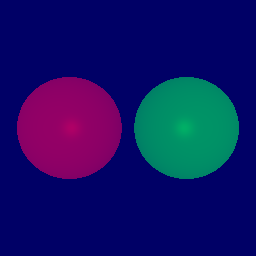

In [39]:
nrows = 256
ncols = 256
f = 250.0

cam = Camera(f, nrows, ncols)
scene = Scene(cam)

for i in range(nrows):
    for j in range(ncols):
        ray = cam.constructRayThroughPixel(i, j)
        hit = scene.find_intersection(ray)
        cam.I[i, j, :] = scene.get_color(hit)

output = img.fromarray(np.uint8(cam.I))
display(output)
output.save('output.png')